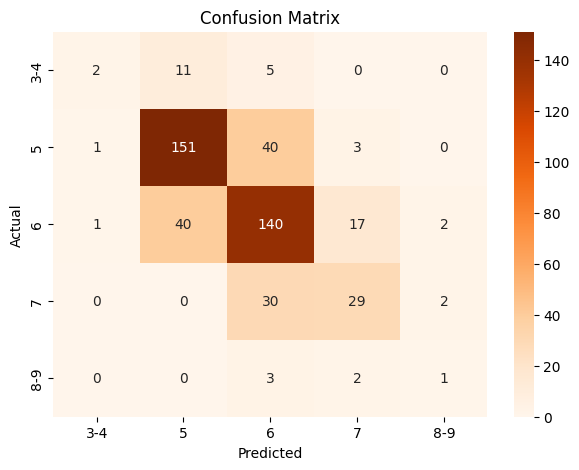


Table of results
----------------
Class  Total  TP  FN  FP  Precision   Recall       F1
  3-4     18   2  16   2   0.500000 0.111111 0.181818
    5    195 151  44  51   0.747525 0.774359 0.760705
    6    200 140  60  78   0.642202 0.700000 0.669856
    7     61  29  32  22   0.568627 0.475410 0.517857
  8-9      6   1   5   4   0.200000 0.166667 0.181818

Accuracy: 0.6729166666666667

Macro AUC: 0.8297063942205545

Ordinal MAE: 0.35625


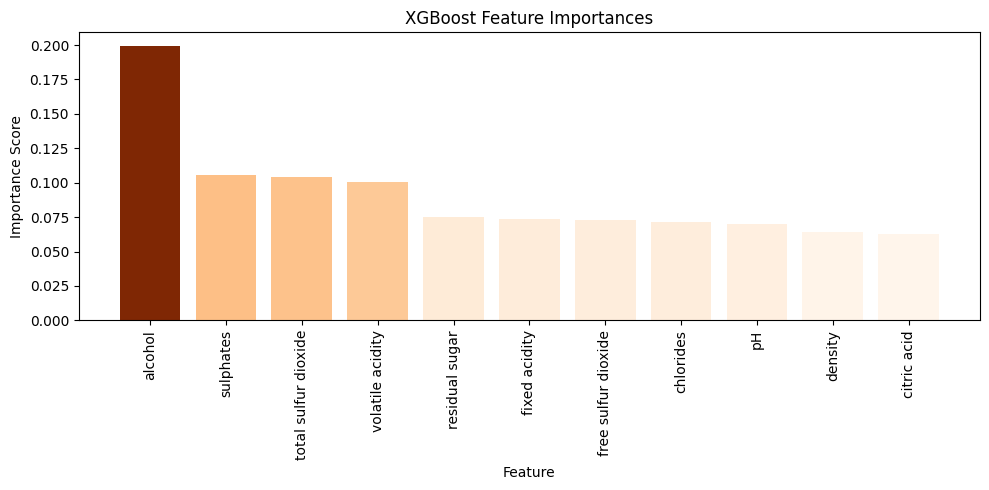

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score

# +++LOAD DATA+++
# ---------------
#df = pd.read_csv("winequality-white.csv", sep=";")
df = pd.read_csv("winequality-red.csv")
X = df.drop("quality", axis=1)
y = df["quality"]



# +++CLASSES INTO GROUPS+++
# -------------------------
mapping = {3: 0, 4: 0, 5: 1, 6: 2, 7: 3, 8: 4, 9: 4}
y_to_groups = y.map(mapping)
labels = ["3-4", "5", "6", "7", "8-9"]




# +++TRAIN/TEST SPLIT+++
# ----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_to_groups,
    test_size=0.3,
    random_state=42
    )



# +++XGBOOST CLASSIFIER MODEL+++
# ------------------------------
model = XGBClassifier(
    learning_rate=0.11,
    n_estimators=600,
)
# Train model
model.fit(X_train, y_train)



# +++PREDICTION+++
# ----------------
y_pred = model.predict(X_test)



#  +++ACCURACY+++
# ---------------
accuracy = accuracy_score(y_test, y_pred)



# +++CONFUSION MATRIX+++
# ----------------------
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4])

plt.figure(figsize=(7, 5))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Oranges",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# +++AUC SCORE+++
# ---------------
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4]) #turns y_test into matrices
y_proba = model.predict_proba(X_test)
auc_macro = roc_auc_score(y_test_bin, y_proba, average="macro")

# +++ORDINAL MAE+++ (how many class levels the model is off on average)
# -----------------
ordinal_mae = np.mean(np.abs(y_test - y_pred))


# +++CLASS-by-CLASS MEASUREMENTS+++
#----------------------------------
rows = []
for i, cls in enumerate([0, 1, 2, 3, 4]):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    support = cm[i, :].sum()

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    rows.append({
        "Class": labels[i],
        "Total": support,
        "TP": TP,
        "FN": FN,
        "FP": FP,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    })

#Print results

df_metrics = pd.DataFrame(rows)
print("\nTable of results\n----------------")
print(df_metrics.to_string(index=False))
print("\nAccuracy:", accuracy)
print("\nMacro AUC:", auc_macro)
print("\nOrdinal MAE:", ordinal_mae)


# +++FEATURE IMPORTANCE+++
# ------------------------
importances = model.feature_importances_
feature_names = np.array(X.columns)

# Sorting A-Z
sorted_idx = np.argsort(importances)[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importances = importances[sorted_idx]
norm = (sorted_importances - sorted_importances.min()) / (sorted_importances.max() - sorted_importances.min())

# Plot
plt.figure(figsize=(10, 5))
plt.bar(sorted_features, sorted_importances, color=plt.cm.Oranges(norm))
plt.xticks(rotation=90)
plt.title("XGBoost Feature Importances")
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()
